#l

In [ ]:
!pip install gym==0.18.3
!pip install atari-py==0.2.5
!pip install gym pyvirtualdisplay 
!pip install wandb

In [ ]:
import gym         
import numpy as np 
import tensorflow.keras as keras       
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply 
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.optimizers import RMSprop, Adam, SGD 
import time                                
import matplotlib.pyplot as plt           
import tensorflow as tf               
import wandb
from collections import deque
from pyvirtualdisplay import Display
import io
import os
import glob
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display


%matplotlib inline

In [ ]:
env = gym.make('SpaceInvaders-v0') 
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
observation = env.reset() 
observation.shape

(210, 160, 3)

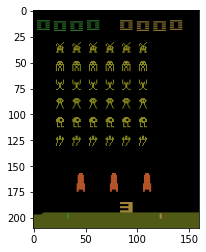

In [ ]:
plt.imshow(observation) 
plt.show() 

#P

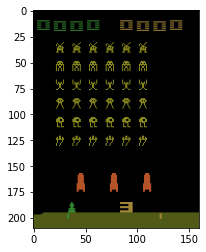

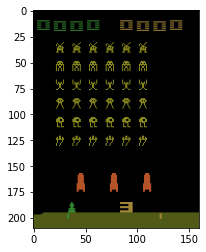

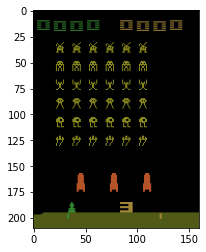

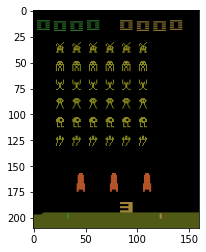

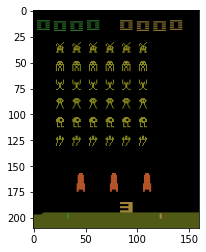

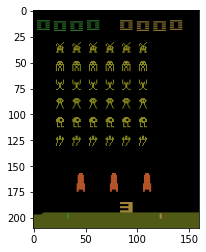

[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[80 89 22]
  [80 89 22]
  [80 89 22]
  ...
  [80 89 22]
  [80 89 22]
  [80 89 22]]

 [[80 89 22]
  [80 89 22]
  [80 89 22]
  ...
  [80 89 22]
  [80 89 22]
  [80 89 22]]

 [[80 89 22]
  [80 89 22]
  [80 89 22]
  ...
  [80 89 22]
  [80 89 22]
  [80 89 22]]] 0.0 False {'ale.lives': 3}


In [ ]:
for i in range(6):
    observation, reward, done, info = env.step(0)
    plt.imshow(observation)                      
    plt.show()

print( observation, reward, done, info)

In [ ]:
def preprocess_frame(obs):
    img = obs[25:201:2, ::2]
    img = img.mean(axis=2)
    img = (img - 128) / 128 - 1
    img = img.reshape(88,80)

    return img 

#E

In [ ]:
cumulative_reward = 0
episode = 0


def evaluate(episodic_reward):
  global episode
  global cumulative_reward
  episode += 1
  print("Episode: %d"%(episode))

  if (episode > 100):
    print("Scores from episodes > 100 won't be logged in wandb.")
    return

  wandb.log({'episodic_reward': episodic_reward})
  cumulative_reward += episodic_reward
  cumulative_avg_reward = cumulative_reward/episode

  wandb.log({'cumulative_avg_reward': cumulative_avg_reward})

#A

In [ ]:
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.learning_rate = wandb.config.learning_rate
        self.epsilon = 1.0
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.05
        self.gamma = 0.95
        self.model = self._build_model()
    
    def _build_model(self):
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(8, activation='relu', input_dim=self.state_size))
        model.add(keras.layers.Dense(16, activation='relu'))
        model.add(keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state):
        return random.randrange(self.action_size)
    
    def save(self, name):
        self.model.save(name)

    def load(self, name):
        self.model.load_weights(name)

In [ ]:
env = gym.make('SpaceInvaders-v0')
wandb.init(project="qualcomm")

wandb.config.episodes = 100
wandb.config.batch_size = 32
wandb.config.learning_rate = 0.003
input_shape = (None, 88, 80, 1)
agent = DQN(state_size, action_size)   

display = Display(visible=0, size=(1400, 900))
display.start()

for i in range(wandb.config.episodes):
  episodic_reward = 0

  env = gym.wrappers.Monitor(env, './video', force=True)

  state = env.reset()
  state = preprocess_frame(state)

  done = False
  while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    next_state = preprocess_frame(next_state)
    agent.remember(state, action, reward, next_state, done)
    state = next_state

    episodic_reward += reward

  evaluate(episodic_reward)

  if len(agent.memory) > wandb.config.batch_size:
    agent.train(wandb.config.batch_size)

  if (i == 99):
    agent.save(os.path.join(wandb.run.dir, "model.h5"))
    break

  record_video = False
  env.close() 


  if (i %50 == 0):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
      print(len(mp4list))
      mp4 = mp4list[-1]
      video = io.open(mp4, 'r+b').read()
      encoded = base64.b64encode(video)

      wandb.log({"gameplays": wandb.Video(mp4, fps=4, format="gif")})

      ipythondisplay.display(HTML(data='''<video alt="" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Episode: 1
1


Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
1


Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Episode: 84
Episode: 85
Episode: 86
Episode: 87
Episode: 88
Episode: 89
Episode: 90
Episode: 91
Episode: 92
Episode: 93
Episode: 94
Episode: 95
Episode: 96
Episode: 97
Episode: 98
Episode: 99
Episode: 100
